In [10]:
import cv2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt


In [24]:
def showImgOld(img, label='Image'):
    
    cv2.imshow(label, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def showImg(img):
    # Convert BGR to RGB (OpenCV uses BGR by default)
    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

(100, 100)
(100, 100)


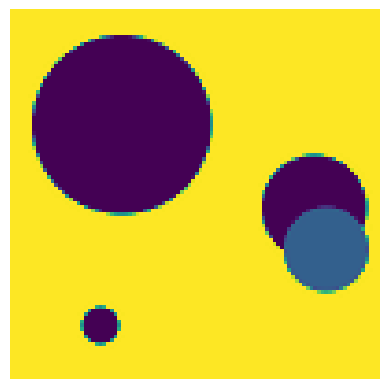

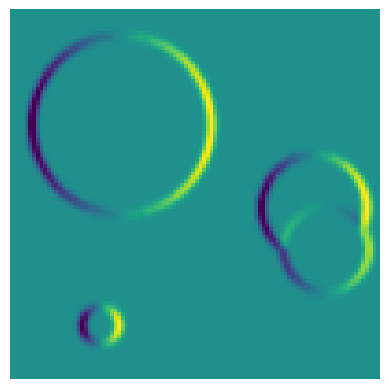

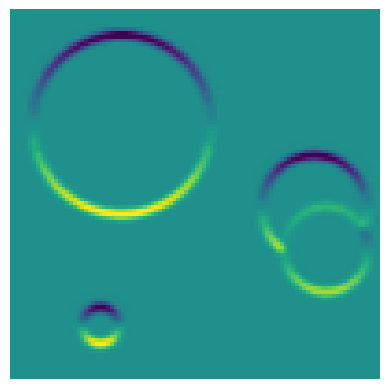

In [25]:
img = cv2.imread('images/four.png', cv2.IMREAD_GRAYSCALE)

sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

print(img.shape)
print(sobelx.shape)

showImg(img)
showImg(sobelx)
showImg(sobely)

